In [31]:
!pip install seaborn

    100% |████████████████████████████████| 215kB 5.7MB/s ta 0:00:01


In [32]:
# disable warnings
import warnings
warnings.filterwarnings('ignore')

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from pgmpy.inference import VariableElimination
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
import seaborn as sns

In [34]:
sns.set_style("whitegrid")

## Credit Card Fraud

In [3]:
df = pd.read_csv('../data/171003_df_cleansed.csv')

In [4]:
print(df.shape)
print(df[df['fraudulent'] == 1].shape)

(15487, 126)
(423, 126)


#### Process data

In [5]:
pd.options.display.max_rows = 4000

In [6]:
df.head(1).T

,0
id,4552758
fraudulent,False
account_id,NaN
analysis_blacklisted,NaN
analysis_score,NaN
buyer_age_of_first_analysis_in_days,NaN
buyer_consecutive_immediate_departure_sales,NaN
buyer_credit_limit,0
buyer_dormancy_in_days,NaN
buyer_identification,17575183000176


In [7]:
df['credit_card_holder_and_passenger_similarity_cat'] = pd.cut(df['credit_card_holder_and_passenger_similarity'], bins=6, include_lowest=True)

In [8]:
df['credit_card_min_age_in_days_cat'] = pd.cut(df['credit_card_min_age_in_days'], bins=20, include_lowest=True)

In [9]:
df['flight_price_per_passenger_cat'] = pd.cut(df['flight_price_per_passenger'], bins=30, include_lowest=True)

In [10]:
df['credit_card_min_sales_count_cat'] =  pd.cut(df['credit_card_min_sales_count'], bins=20, include_lowest=True)

In [11]:
df['credit_card_max_sales_count_24h_cat'] =  pd.cut(df['credit_card_max_sales_count_24h'], bins=20, include_lowest=True)

In [12]:
df['flight_hours_to_departure_cat'] =  pd.cut(df['flight_hours_to_departure'], bins=20, include_lowest=True)

In [13]:
df['credit_card_holder_diff_cat'] =  pd.cut(df['credit_card_holder_diff'], bins=5, include_lowest=True)

In [14]:
df['credit_card_last_names_association_count_cat'] = pd.cut(df['credit_card_last_names_association_count'], bins=5, include_lowest=True)

In [15]:
df["flight_origin_destination_iata"] = df["flight_origin_iata"] + df["flight_destination_iata"]

In [16]:
df.credit_card_holder_and_passenger_similarity_cat.unique()

[(0.333, 0.667], (-0.333, 0], (0, 0.333], (0.667, 1], [-1.002, -0.667]]
Categories (5, object): [[-1.002, -0.667] < (-0.333, 0] < (0, 0.333] < (0.333, 0.667] < (0.667, 1]]

In [17]:
#filter features
data = df[[
    'credit_card_holder_and_passenger_similarity_cat',
    'credit_card_min_age_in_days_cat',
    'flight_price_per_passenger_cat',
    'credit_card_min_sales_count_cat',
    'credit_card_max_sales_count_24h_cat',
    'flight_hours_to_departure_cat',
    'credit_card_holder_diff_cat',
    'credit_card_last_names_association_count_cat',
#     'flight_origin_destination_iata',
    'payment_attempts_count',
    'fraudulent',
    'flight_international',
    'flight_travel_type'
]]

#### Explore data

#### Structure learning

In [23]:
hc = HillClimbSearch(data, scoring_method=BicScore(data))
best_model = hc.estimate()
print(best_model.edges())

[('flight_hours_to_departure_cat', 'fraudulent'), ('flight_international', 'flight_hours_to_departure_cat'), ('flight_international', 'credit_card_holder_and_passenger_similarity_cat'), ('flight_international', 'flight_price_per_passenger_cat'), ('flight_international', 'payment_attempts_count'), ('flight_travel_type', 'flight_hours_to_departure_cat'), ('flight_travel_type', 'flight_price_per_passenger_cat'), ('flight_travel_type', 'flight_international'), ('fraudulent', 'credit_card_holder_and_passenger_similarity_cat'), ('fraudulent', 'payment_attempts_count'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_min_sales_count_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_holder_diff_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_last_names_association_count_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_max_sales_count_24h_cat'), ('credit_card_holder_and_passenger_similarity_cat', 'credit_card_

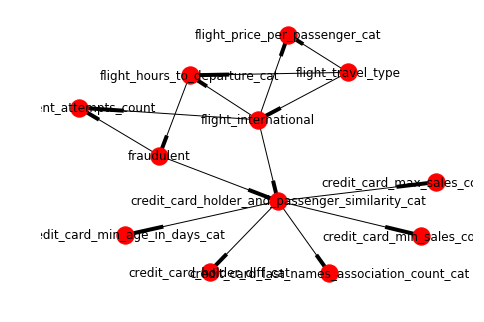

In [24]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show()

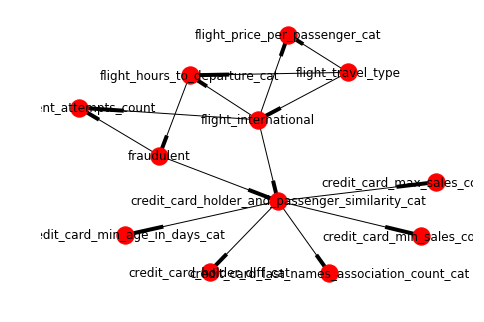

In [25]:
nx.draw(best_model, with_labels=True, pos=graphviz_layout(best_model))
plt.show()

In [26]:
best_model.edges()

[('flight_hours_to_departure_cat', 'fraudulent'),
 ('flight_international', 'flight_hours_to_departure_cat'),
 ('flight_international', 'credit_card_holder_and_passenger_similarity_cat'),
 ('flight_international', 'flight_price_per_passenger_cat'),
 ('flight_international', 'payment_attempts_count'),
 ('flight_travel_type', 'flight_hours_to_departure_cat'),
 ('flight_travel_type', 'flight_price_per_passenger_cat'),
 ('flight_travel_type', 'flight_international'),
 ('fraudulent', 'credit_card_holder_and_passenger_similarity_cat'),
 ('fraudulent', 'payment_attempts_count'),
 ('credit_card_holder_and_passenger_similarity_cat',
  'credit_card_min_sales_count_cat'),
 ('credit_card_holder_and_passenger_similarity_cat',
  'credit_card_holder_diff_cat'),
 ('credit_card_holder_and_passenger_similarity_cat',
  'credit_card_last_names_association_count_cat'),
 ('credit_card_holder_and_passenger_similarity_cat',
  'credit_card_max_sales_count_24h_cat'),
 ('credit_card_holder_and_passenger_similari

In [27]:
best_model.nodes()

['flight_hours_to_departure_cat',
 'credit_card_last_names_association_count_cat',
 'credit_card_max_sales_count_24h_cat',
 'flight_international',
 'credit_card_holder_diff_cat',
 'flight_price_per_passenger_cat',
 'flight_travel_type',
 'payment_attempts_count',
 'credit_card_min_sales_count_cat',
 'fraudulent',
 'credit_card_holder_and_passenger_similarity_cat',
 'credit_card_min_age_in_days_cat']

In [29]:
infer = VariableElimination(best_model)

ValueError: No CPD associated with flight_hours_to_departure_cat

In [ ]:
infer.map_query('fraudulent')